In [1]:
import sys

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import scipy.stats as stats
from scipy.fft import fft, fftfreq
import scipy.signal as sig
from sklearn import linear_model

sys.path.append("../../../code/ndsvae/")
import ndsvae as ndsv

sys.path.append("..")
import plot
import util

%matplotlib inline

## Set matplotlib

In [2]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Load data

In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    

def get_results(testcase, config, runs):
    modelname = "AN"
    path = f"../run/main/{testcase}/model{modelname}/{config}"
    ds = ndsv.Dataset.from_file(f"../run/main/{testcase}/dataset.npz")
    surr   = ndsv.GeneratedData.from_file(f"../run/main/{testcase}/surrogates.npz")
    sims   = ndsv.GeneratedData.from_file(f"{path}/run{run:02d}/simulations.npz")
    params = ndsv.Params.from_file(f"{path}/run{run:02d}/parameters.npz")
        
    return dotdict(ds=ds, sims=sims, params=params, surr=surr)

resh = get_results("hopf",     "ns_2_mreg_2_msub_1_nf_32", [0,1])
resp = get_results("pmfm_avg", "ns_2_mreg_2_msub_1_nf_32", [0,1])

## Plotting 

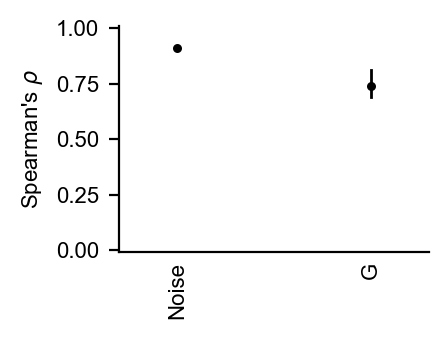

In [4]:
def get_rhos(ptru, pest, nsamples):
    """
    ptru ... Ground truth, shape (n,)
    pest ... Estimated parameters (Gaussians, mu and std in last dimension), shape (n, m, 2)
    n = number of parameters, m = dimensionality of the estimated parameter space
    
    Returns array of shape (nsamples) with Spearman's rho
    """
    
    # Find projection matrix from means
    linreg = linear_model.LinearRegression().fit(pest[:,:,0], ptru)
    
    rhos = np.zeros(nsamples)
    for i in range(nsamples):
        pest_samples = np.random.normal(pest[:,:,0], pest[:,:,1])
        pest_samples_projected = linreg.predict(pest_samples)
                        
        rhos[i] = stats.spearmanr(ptru, pest_samples_projected)[0]
                
    return rhos  


def axbottomleft(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    

def plot_paramfit_hopf(ax, ds, params, athr=0.):
    nsub, nreg, mreg, _ = params.thetareg.shape
    nsamples = 100
    
    atru = ds.thetareg[:,:,0].reshape(nsub*nreg)
    ftru = ds.thetareg[:,:,1].reshape(nsub*nreg)
    mask = atru > athr
    
    rhos_a  = get_rhos(atru, params.thetareg.reshape((nsub*nreg, mreg, 2)), nsamples)
    rhos_f  = get_rhos(ftru, params.thetareg.reshape((nsub*nreg, mreg, 2)), nsamples)
    rhos_fp = get_rhos(ftru[mask], params.thetareg.reshape((nsub*nreg, mreg, 2))[mask], nsamples)    
    rhos_g  = get_rhos(ds.thetasub[:,0], params.thetasub, nsamples)
    
    rhos = [rhos_a, rhos_f, rhos_fp, rhos_g]
    labels = ["a", "f (all)", f"f (a>{athr})", "G"]
    
    plt.sca(ax)
    for i in range(len(rhos)):    
        plt.plot([i,i], np.percentile(rhos[i], [5,95]), lw=1, color='k')
        plt.scatter(i, np.median(rhos[i]), color='k', s=5, clip_on=False)
    plt.xticks(np.r_[:len(rhos)], labels, rotation='vertical')
    plt.xlim(-0.3, len(rhos)-0.7)
    ax.tick_params(axis='x', which='both',length=0)
    
    # plt.ylim(top=1.02)
    plt.ylim(-0.01, 1.01)
    plt.ylabel("Spearman's $\\rho$")
    
    axbottomleft(ax)


def plot_paramfit_pmfm(ax, ds, params):    
    nsub, nreg, mreg, _ = params.thetareg.shape
    nsamples = 100
    
    sigtru = ds.thetareg[:,:,0].reshape(nsub*nreg)
    rhos_sig  = get_rhos(sigtru, params.thetareg.reshape((nsub*nreg, mreg, 2)), nsamples)
    rhos_g  = get_rhos(ds.thetasub[:,0], params.thetasub, nsamples)
    
    rhos = [rhos_sig, rhos_g]
    labels = ["Noise", "G"]
    
    plt.sca(ax)
    for i in range(len(rhos)):        
        plt.plot([i,i], np.percentile(rhos[i], [5,95]), lw=1, color='k')
        plt.scatter(i, np.median(rhos[i]), color='k', s=5, clip_on=False)
    plt.xticks(np.r_[:len(rhos)], labels, rotation='vertical')
    plt.xlim(-0.3, len(rhos)-0.7)
    ax.tick_params(axis='x', which='both',length=0)
    
    # plt.ylim(top=1.02)
    plt.ylim(-0.01, 1.01)
    plt.ylabel("Spearman's $\\rho$")
    
    axbottomleft(ax)
    
    
plt.figure(figsize=(2,1.5), dpi=200)
plot_paramfit_pmfm(plt.gca(), resp.ds, resp.params)

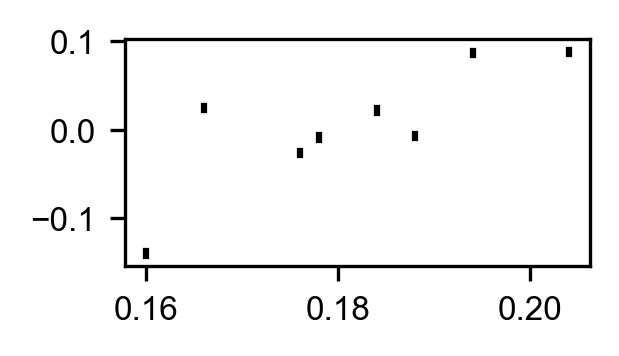

In [5]:
resp.ds.thetasub[:,0], resp.params.thetasub[:,0,0]

plt.figure(figsize=(2,1), dpi=300)
for i in range(8):
    pos = resp.ds.thetasub[i,0]
    mu = resp.params.thetasub[i,0,0]
    std = resp.params.thetasub[i,0,1]
    plt.plot([pos, pos], [mu-std, mu+std], color='k')

In [6]:
# plt.hist(resp.ds.y.ravel(), bins=41);

In [7]:
def get_mode_limits(y, separating_mass, npoints):
    npoints = 201
    
    lims = np.min(y), np.max(y)
    x = np.linspace(lims[0], lims[1], npoints)    
    pdf, _ = np.histogram(y, bins=x, density=True)
    pdf /= np.sum(pdf)
    cdf = np.cumsum(pdf)

    def mass_interval(cdf, i):
        try:
            return (i, np.where(cdf - cdf[i] >= separating_mass)[0][0])
        except IndexError:
            return None

    mass_intervals = [mass_interval(cdf, i) for i in range(npoints)]
    dists = np.array([(mi[1] - mi[0]) if mi is not None else 0 for mi in mass_intervals])
    
    # To ignore the boundaries
    dists[:-1][cdf < separating_mass] = 0.
    
    ind = np.argmax(dists)
    i1, i2 = mass_intervals[ind]
    
    return x[i1], x[i2]
    
MODE_LIMITS = get_mode_limits(resp.ds.y.ravel(), 0.1, 201)

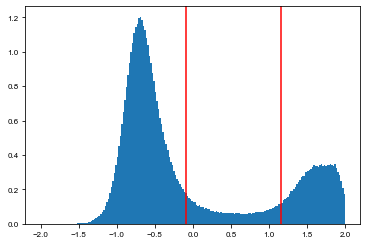

In [8]:
plt.hist(resp.ds.y.ravel(), bins=np.linspace(-2,2,201), density=True);
plt.axvline(MODE_LIMITS[0], color='r')
plt.axvline(MODE_LIMITS[1], color='r')

In [21]:
def plot_ci(pos, x, q, color='k', ls='-', zorder=None):
    plt.plot([pos,pos], np.nanpercentile(x, q), lw=1, color=color, ls=ls, zorder=zorder)
    plt.scatter(pos, np.nanmedian(x), color=color, s=5, zorder=zorder)    

    
def nswitches(y, axis):
    """Calculates number of switches along the axis"""        
    y = np.moveaxis(y, [axis] + list(np.r_[:axis]), [0] + list(np.r_[1:axis+1]))
    
    state = np.zeros_like(y, dtype=int)
    state[y < MODE_LIMITS[0]] = -1
    state[y > MODE_LIMITS[1]] = 1
    
    nt = y.shape[0]
    
    state[0][state[0] == 0] = 1
    for i in range(1,nt):
        mask = (state[i] == 0)
        state[i][mask] = state[i-1][mask]
      
    return np.log(np.sum((state[1:] - state[:-1]) != 0, axis=0) + 1)

        
def absdiff(x, y):
    return np.abs(x - y)

def smooth(y, box_pts, axis=-1):
    # Move desired axis to 0-th axis
    y = np.moveaxis(y, [axis] + list(np.r_[:axis]), [0] + list(np.r_[1:axis+1]))
    shape = y.shape
    
    # Flatten all other axes
    y = np.reshape(y, (y.shape[0], -1))
    ysmooth = np.zeros_like(y)
    
    # Convolve
    box = np.ones(box_pts)/box_pts
    for i in range(y.shape[1]):
        ysmooth[:,i] = np.convolve(y[:,i], box, mode='same')
        
    # Reshape and move again
    ysmooth = np.reshape(ysmooth, shape)
    ysmooth = np.moveaxis(ysmooth, [0] + list(np.r_[1:axis+1]), [axis] + list(np.r_[:axis]))
    
    return ysmooth


def get_smooth_spectrum_fun(fs, nsmooth):
    def smooth_spectrum(y, axis):
        f, pxx = sig.periodogram(y, fs=fs, axis=axis)
        pxx = smooth(pxx, nsmooth)
        return pxx
    return smooth_spectrum

    
def cosine_similarity(a, b):
    return np.sum(a * b, axis=-1)/(np.sqrt(np.sum(a * a, axis=-1) * np.sum(b * b, axis=-1)))   
    
    
def identity(x, axis):
    return x


def wdist(x, y):
    assert x.shape[0] == 1
    nsamples, npoints, nt = y.shape
    
    bins = np.linspace(-2, 2, 20+1)
    centers = (bins[1:] + bins[:-1])/2.
    dist = np.zeros((nsamples, npoints))
    
    for j in range(npoints):
        px = np.histogram(x[0,j], bins, density=True)[0]
        px /= np.sum(px)    
        
        for i in range(nsamples):
            py = np.histogram(y[i,j], bins, density=True)[0]
            py /= np.sum(py)
            dist[i,j] = stats.wasserstein_distance(centers, centers, px, py)
    return dist    
    
    
def plot_featurefit(ax, ds, sims, surr, feature, similarity, feature_label=None, similarity_label=None,
                    examples=None, legend=False, mask=None):
    
    nsub, nreg, _, nt = ds.y.shape
    nsamples = sims.y.shape[0]
    nsurr = surr.y.shape[0]
    n = nsub*nreg
    
    if examples is None:
        examples = []
        
    if mask is None:
        mask = np.ones((nsub, nreg), dtype=bool)
    
    # Data
    ysim = ds.y.reshape((n, nt))[None,:,:]
    ygen = sims.y[:,:,:,:,-nt:].reshape((nsamples, n, nt))
    ysu1 = surr.y.reshape((nsurr, n, nt))
    ysu2 = ysim[:,np.random.permutation(n),:]
    ysu3 = np.random.normal(0, 1, (n, nt))[None,:,:]
    mask = np.reshape(mask, n)
    
    # Features       
    fsim = feature(ysim, axis=-1)
    fgen = feature(ygen, axis=-1)
    fsu1 = feature(ysu1, axis=-1)
    fsu2 = feature(ysu2, axis=-1)
    fsu3 = feature(ysu3, axis=-1)

    # Similarity measures
    sim_gen = similarity(fsim, fgen)
    sim_su1 = similarity(fsim, fsu1)
    sim_su2 = similarity(fsim, fsu2)
    sim_su3 = similarity(fsim, fsu3)

    # Plot
    plt.sca(ax)
    plot_ci(0.00, sim_gen[:,mask].ravel(), [5,95], 'k')
    plot_ci(0.15, sim_su1[:,mask].ravel(), [5,95], '0.6', '-')
    plot_ci(0.30, sim_su2[:,mask].ravel(), [5,95], 'k', '--')
    plot_ci(0.45, sim_su3[:,mask].ravel(), [5,95], 'k', ':')

    for (isub, ireg, isample, color) in examples:
        sim_ex = sim_gen[isample, nreg*isub + ireg]
        plt.scatter(-0.15, sim_ex, fc=color, ec='k', lw=0.3, s=10)            

    if similarity_label:
        plt.ylabel(similarity_label)

    axbottomleft(ax)    
    plt.xlim(-0.3, 0.5)
    plt.xticks([])
    if feature_label:
        plt.xlabel(feature_label)
    if similarity_label == "Cosine similarity":
        plt.ylim(top=1.05)



examples_hopf = [(2, 43, 11,'tab:blue'), (2, 53, 11, 'tab:red'), (2, 61, 11, 'tab:green')]
    
# plt.figure(figsize=(1,1), dpi=200)
# plot_featurefit(plt.gca(), resp.ds, resp.sims, resp.surr, np.mean, absdiff, "Mean", "Difference", 
#                 examples=examples_hopf, legend=False)
# plot_featurefit(plt.gca(), resp.ds, resp.sims, resp.surr, identity, wdist, 
#                 "Samples", "Bhattacharyya dist", examples=examples_hopf, legend=False)
# plt.ylim(0,0.3)

In [22]:
def plot_fc_similarity(ax, ds, sims, surr, gformat=None, examples=None):
    nsub, nreg, _, nt = ds.y.shape
    nsamples = sims.y.shape[0]
    nsurr = surr.y.shape[0]
    
    triu = np.triu_indices(nreg, k=1)
    median_fc = np.zeros(nsub)
    
    if examples is None:
        examples = []
    
    for i in range(nsub):
        fc = np.corrcoef(ds.y[i,:,0,:])
        median_fc[i] = np.mean(fc[triu])
        
        fc_gen = [np.corrcoef(sims.y[j,i,:,0,:]) for j in range(nsamples)]
        fc_sur = [np.corrcoef(surr.y[j,i,:,0,:]) for j in range(nsurr)]
        
        pc_gen = [np.corrcoef(fc[triu], fc2[triu])[0,1] for fc2 in fc_gen]
        pc_sur = [np.corrcoef(fc[triu], fc2[triu])[0,1] for fc2 in fc_sur]
        
        plot_ci(i, pc_gen, [5,95], color='k', ls='-', zorder=10)
        plot_ci(i+0.25, pc_sur, [5,95], color='0.6', ls='-', zorder=0)
                
    for isub, isample in examples:
        fc = np.corrcoef(ds.y[isub,:,0,:])
        fc2 = np.corrcoef(sims.y[isample,isub,:,0,:])
        pc = np.corrcoef(fc[triu], fc2[triu])[0,1]
        plt.scatter(isub-0.25, pc, ec='k', fc='w', s=8, lw=0.5, zorder=20)
        
    plt.ylabel("Pearson correlation\nof FC elements")
    plt.ylim(-0.05, 1.0)
        
    plt.xticks(np.r_[:nsub], np.r_[:nsub]+1)
    plt.xlabel("Subject")
    
    if gformat is not None:
        ax3 = plt.twiny()
        plt.xticks(np.r_[:nsub], [f"{ds.thetasub[i,0]:{gformat}}" for i in range(nsub)], fontsize=6,
                   rotation='vertical')
        plt.xlabel("Coupling coefficient G")
    
    
# plt.figure(figsize=(2.5,1.5), dpi=200)
# plot_fc_similarity(plt.gca(), resh.ds, resh.sims, resh.surr, glabel=True, examples=[(3,8)])

# plt.figure(figsize=(2.5,1.5), dpi=200)
# plot_fc_similarity(plt.gca(), resp.ds, resp.sims, resp.surr, glabel=False, examples=[(2,11)])

In [23]:
def plot_fcmean(ax, ds, sims, surr, lim=None):    
    nsamples, nsub, nreg = sims.y.shape[:3]
    nsurr = surr.y.shape[0]
    triu = np.triu_indices(nreg, k=1)

    lim_ = 0.
    for i in range(nsub):
        fc1 = np.corrcoef(ds.y[i,:,0,:])
        fc2 = [np.corrcoef(sims.y[j,i,:,0,:]) for j in range(nsamples)]
        fc3 = [np.corrcoef(surr.y[j,i,:,0,:]) for j in range(nsurr)]

        mfc1 = np.mean(fc1[triu])
        mfc2 = [np.mean(fc[triu]) for fc in fc2]
        mfc3 = [np.mean(fc[triu]) for fc in fc3]

        plot_ci(mfc1, mfc2, [5,95], color='k', ls='-', zorder=10)
        plot_ci(mfc1, mfc3, [5,95], color='0.6', ls='-', zorder=2)

        lim_ = np.max([lim_, mfc1, np.percentile(mfc2, 95), np.percentile(mfc3, 95)])        
        
    plt.xlabel("Mean FC (data)")
    plt.ylabel("Mean FC\n(prediction)")

    if lim is None:           
        lim = (-lim_, lim_)
    plt.plot(lim, lim, ls='--', color='k', lw=0.4, zorder=-4)    
    
    lim = (lim[0] - 0.03*(lim[1]-lim[0]), lim[1] + 0.03*(lim[1]-lim[0]))
    loc = matplotlib.ticker.MultipleLocator(base=np.around((lim[1]-lim[0])/2., 1))
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    plt.xlim(lim)
    plt.ylim(lim)
    # ax.locator_params(nbins=4, axis='both')


    
# plt.figure(figsize=(1,1), dpi=200)
# plot_fcmean(plt.gca(), resh.ds, resh.sims, resh.surr)

# plt.figure(figsize=(1,1), dpi=200)
# plot_fcmean(plt.gca(), resp.ds, resp.sims, resp.surr)

In [24]:
def add_legend(ax):
    plt.sca(ax)
    plt.plot([-1,-1], [0,0], color='w', marker='o', markerfacecolor='w', markeredgewidth=0.4,
         markeredgecolor='k', markersize=3, label="Examples")
    plt.plot([0,0], [0,0], 'k',   label="Trained model")
    plt.plot([0,0], [0,0], '0.6', label="Original model")
    plt.plot([0,0], [0,0], 'k--', label="Reshuffled")
    plt.plot([0,0], [0,0], 'k:',  label="Noise")

    plt.legend(ncol=2, loc='upper left', borderaxespad=0.)
    plt.xlim(0,1); plt.ylim(0,1)
    plt.axis('off')

## Plot the figure

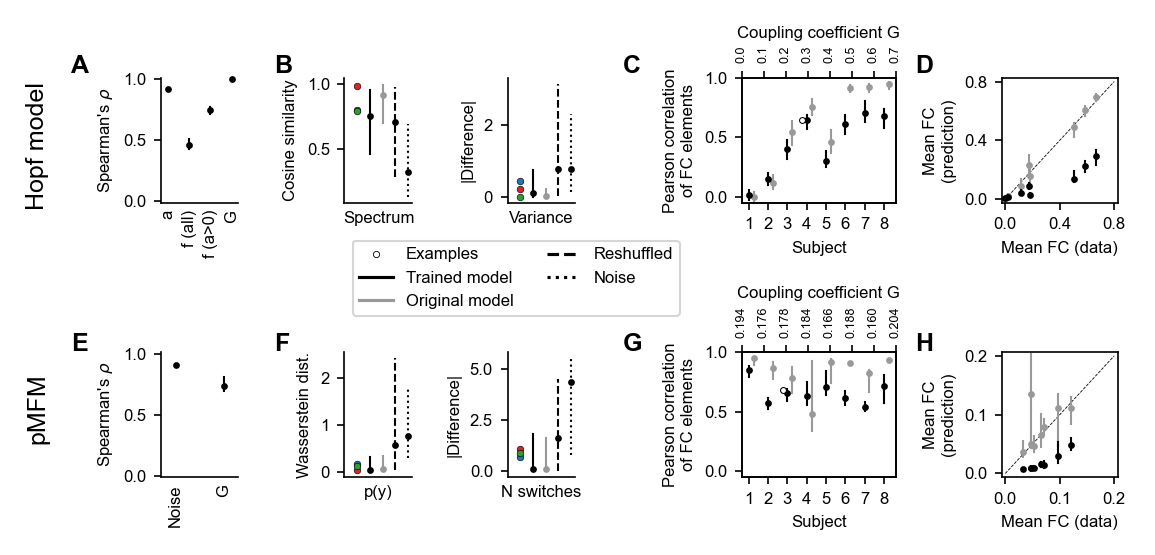

In [29]:
fig = plt.figure(figsize=(7.5, 3.5), dpi=150)


gs = GridSpec(2, 5, left=0.13, right=0.98, top=0.88, bottom=0.12, hspace=1.2, wspace=1.,
              width_ratios=([1, 3, -0.6, 2, 1.5]))

# Evaluation of parameter fit
axa = plt.subplot(gs[0,0])
plot_paramfit_hopf(axa, resh.ds, resh.params, athr=0)

axd = plt.subplot(gs[1,0])
plot_paramfit_pmfm(axd, resp.ds, resp.params)

# Feature fit: Hopf
ex = [(3, 24, 45, 'tab:blue'), (3, 37, 45, 'tab:red'), (3, 58, 45, 'tab:green')]
gsb = gs[0,1].subgridspec(1, 2, wspace=1.4)
axb1, axb2 = plt.subplot(gsb[0]), plt.subplot(gsb[1])
funss = get_smooth_spectrum_fun(1./(resh.ds.t[1] - resh.ds.t[0]), 3)
plot_featurefit(axb1, resh.ds, resh.sims, resh.surr, funss, cosine_similarity, "Spectrum", "Cosine similarity",
                examples=ex)
plot_featurefit(axb2, resh.ds, resh.sims, resh.surr, np.var, absdiff, "Variance", "|Difference|", examples=ex)

# Feature fit: pMFM
ex = [(2, 43, 34,'tab:blue'), (2, 53, 34, 'tab:red'), (2, 61, 33, 'tab:green')]
gse = gs[1,1].subgridspec(1, 2, wspace=1.4)
axe1, axe2 = plt.subplot(gse[0]), plt.subplot(gse[1])
plot_featurefit(axe1, resp.ds, resp.sims, resp.surr, identity, wdist, "p(y)", "Wasserstein dist.", 
                examples=ex)
plot_featurefit(axe2, resp.ds, resp.sims, resp.surr, nswitches, absdiff, "N switches", "|Difference|",
                examples=ex)

# FC similarity
axc = plt.subplot(gs[0,3])
plot_fc_similarity(axc, resh.ds, resh.sims, resh.surr, gformat="2.1f", examples=[(3,45)])

axf = plt.subplot(gs[1,3])
plot_fc_similarity(axf, resp.ds, resp.sims, resp.surr, gformat="5.3f", examples=[(2,34)])

axc2 = plt.subplot(gs[0,4])
plot_fcmean(axc2, resh.ds, resh.sims, resh.surr, (0.0, 0.8))

axf2 = plt.subplot(gs[1,4])
plot_fcmean(axf2, resp.ds, resp.sims, resp.surr, (0.0, 0.2))


# Shared legend
ax = fig.add_axes([0.3, 0.50, 0.3, 0.07])
add_legend(ax)

bg = plot.Background(visible=False, spacing=0.1)

bg.labels([0.05, 0.23, 0.54, 0.80, 0.05, 0.23, 0.54, 0.80],
          [0.88, 0.88, 0.88, 0.88, 0.35, 0.35, 0.35, 0.35], fontsize=12)
bg.axes.text(0.01, 0.75, "Hopf model", va='center', ha='left', fontsize=12, rotation='vertical')
bg.axes.text(0.01, 0.25, "pMFM",       va='center', ha='left', fontsize=12, rotation='vertical')


plt.savefig("./img/Fig_QuantComparison.pdf")